# Macroeconomic Scenario Projections

**Purpose:** Estimate directional impacts of macroeconomic stress on payment volumes and fraud rates using scenario-based analysis.

**Audience:** Leadership and engineering teams

**Date:** December 2025

---

## Disclaimer

**This is scenario-based analysis, NOT predictive forecasting.**

- Scenarios are hypothetical stress conditions designed to illustrate potential directional impacts
- Estimates are based on simple linear sensitivities derived from historical relationships
- Actual outcomes will depend on numerous factors not captured in these scenarios
- Use these projections for planning and risk awareness, not as precise predictions

---

## Key Analyst Hypotheses

Based on the Macro Risk Assessment document (December 2025), the following relationships between macroeconomic conditions and payment behavior have been identified:

### 1. First-Party Fraud Risk (SUPPORTED)

**Historical Evidence:**
- Chargebacks increased +12-18% with 3-6 month lag after unemployment spikes (2009-2010)
- Friendly fraud concentrated 63% in non-essential categories
- Application fraud (income/employment misrepresentation) increased +22% during 2008-2010
- Default risk +40% higher for fraudulent applicants

**Current Context:**
- Credit stress elevated (charge-offs at 4.17%)
- Consumer sentiment severely depressed (53.6 vs 101.0 pre-cycle)
- Unemployment stable at 4.4% (moderates risk vs 2008-2010)
- Stress driver is rates/inflation, not job loss

### 2. Disputes & Chargeback Activity (VALIDATED)

**Historical Evidence:**
- Non-essential payment volume declined -8% to -12% (2010-2015)
- Fee complaint inquiries increased +23% during 2015 cycle
- Disputes concentrated in discretionary spend categories
- Merchant win-rate declined -8 percentage points (2009-2010)

**Current Context:**
- All relevant indicators exceed prior tightening cycles
- Risk likely near historic upper bounds

### 3. Third-Party Fraud (UNSUPPORTED)

**Historical Evidence:**
- Account takeover driven by breaches, not economics
- Synthetic identity fraud shows continuous growth (+280% since 2008)
- Primary drivers: data availability, criminal sophistication, detection gaps

**Implication:**
- No macro-driven adjustment recommended for third-party fraud

### 4. Abnormal Payment Behavior (SUPPORTED)

**Historical Patterns (2010-2015):**
- Payment method migration: ACH share increased from 42% to 51%
- Accelerated debt repayment: average payment amount +18%
- Credit utilization reduction: 42% to 34%
- Anticipatory behavior: changes appear 6-9 months before rate hikes

**Risk Implications:**
- Rule sensitivity to payment method mix changes
- False positives on unusually large payments
- Fraud rate distortion due to behavior shifts

---

## Scenario Definitions

We define three scenarios representing different levels of macroeconomic stress:

### Baseline Scenario
**Conditions:**
- Unemployment: 4.0% (near current stable levels)
- Fed Funds Rate: 3.5% (moderate, declining from peak)
- Consumer sentiment: ~70 (recovering from trough)
- Credit stress indicators: stable

**Expected Impact:**
- Normal payment volumes and patterns
- Baseline fraud rates
- Gradual moderation from current elevated stress

### Moderate Stress Scenario
**Conditions:**
- Unemployment: 5.5-6.0% (rising but not crisis levels)
- Fed Funds Rate: 4.5-5.0% (elevated but not at recent peak)
- Consumer sentiment: ~55 (similar to recent trough)
- Credit stress: moderately elevated (charge-offs 3.5-4.0%)

**Expected Impact:**
- Moderate reduction in discretionary transaction volume (-5% to -8%)
- First-party fraud and disputes elevated (+10% to +15%)
- Payment behavior shifts becoming evident

### Severe Stress Scenario
**Conditions:**
- Unemployment: 7.5-8.0% (approaching 2008-2010 levels)
- Fed Funds Rate: 5.5%+ (at or above recent peak, sustained)
- Consumer sentiment: <50 (severe deterioration)
- Credit stress: severely elevated (charge-offs 5.0%+)

**Expected Impact:**
- Significant reduction in discretionary volume (-12% to -18%)
- Sharp increase in first-party fraud (+18% to +25%)
- Material behavior shifts affecting model performance
- Elevated disputes and chargebacks

---

## Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load internal metrics
print("Loading data...\n")

# Monthly internal metrics
monthly_metrics = pd.read_csv('../data/synthetic/monthly_internal_metrics.csv')
monthly_metrics['year_month'] = pd.to_datetime(monthly_metrics['year_month'])
print(f"✓ Monthly metrics: {len(monthly_metrics)} months")

# FRED macroeconomic data
fed_funds = pd.read_csv('../data/fred/federal_funds_rate.csv')
fed_funds['date'] = pd.to_datetime(fed_funds['date'])

unemployment = pd.read_csv('../data/fred/unemployment_rate.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])

cpi = pd.read_csv('../data/fred/consumer_price_index.csv')
cpi['date'] = pd.to_datetime(cpi['date'])

print(f"✓ FRED data: {len(fed_funds)} months")

# Stress period analysis (pre-computed)
stress_analysis = pd.read_csv('../data/fred/stress_period_analysis.csv')
print(f"✓ Stress period analysis loaded")

print("\nData loaded successfully!")

Loading data...

✓ Monthly metrics: 47 months
✓ FRED data: 47 months
✓ Stress period analysis loaded

Data loaded successfully!


In [3]:
# Merge macro data with internal metrics
macro_data = fed_funds.merge(unemployment, on='date', how='inner')
macro_data = macro_data.merge(cpi, on='date', how='inner')

# Merge with monthly metrics
combined_data = monthly_metrics.merge(
    macro_data,
    left_on='year_month',
    right_on='date',
    how='inner'
)

print(f"Combined dataset: {len(combined_data)} months")
print(f"Date range: {combined_data['year_month'].min()} to {combined_data['year_month'].max()}")
print(f"\nColumns: {list(combined_data.columns)}")

Combined dataset: 45 months
Date range: 2022-01-01 00:00:00 to 2025-09-01 00:00:00

Columns: ['year_month', 'monthly_transaction_volume', 'monthly_revenue_usd', 'monthly_new_customers', 'avg_churn_rate_pct', 'avg_response_time_ms', 'avg_uptime_pct', 'avg_fraud_detection_rate_pct', 'avg_false_positive_rate_pct', 'date', 'federal_funds_rate_percent', 'unemployment_rate_percent', 'cpi_index']


---

## Baseline Analysis

First, let's establish baseline metrics from recent data.

In [4]:
# Use most recent 6 months as baseline
baseline_data = combined_data.nlargest(6, 'year_month')

baseline_metrics = {
    'avg_monthly_volume': baseline_data['monthly_transaction_volume'].mean(),
    'avg_monthly_revenue': baseline_data['monthly_revenue_usd'].mean(),
    'avg_fraud_detection_rate': baseline_data['avg_fraud_detection_rate_pct'].mean(),
    'avg_false_positive_rate': baseline_data['avg_false_positive_rate_pct'].mean(),
    'avg_churn_rate': baseline_data['avg_churn_rate_pct'].mean(),
    'unemployment_rate': baseline_data['unemployment_rate_percent'].mean(),
    'fed_funds_rate': baseline_data['federal_funds_rate_percent'].mean(),
}

print("="*70)
print("BASELINE METRICS (Last 6 Months)")
print("="*70)
print(f"\nTransaction Volume:")
print(f"  Average monthly volume: {baseline_metrics['avg_monthly_volume']:,.0f} transactions")
print(f"  Average monthly revenue: ${baseline_metrics['avg_monthly_revenue']:,.2f}")
print(f"\nFraud & Risk Metrics:")
print(f"  Fraud detection rate: {baseline_metrics['avg_fraud_detection_rate']:.2f}%")
print(f"  False positive rate: {baseline_metrics['avg_false_positive_rate']:.2f}%")
print(f"  Customer churn rate: {baseline_metrics['avg_churn_rate']:.2f}%")
print(f"\nMacro Context:")
print(f"  Unemployment rate: {baseline_metrics['unemployment_rate']:.2f}%")
print(f"  Fed funds rate: {baseline_metrics['fed_funds_rate']:.2f}%")
print("="*70)

BASELINE METRICS (Last 6 Months)

Transaction Volume:
  Average monthly volume: 38,687 transactions
  Average monthly revenue: $1,935,083.45

Fraud & Risk Metrics:
  Fraud detection rate: 84.37%
  False positive rate: 3.09%
  Customer churn rate: 2.47%

Macro Context:
  Unemployment rate: 4.23%
  Fed funds rate: 4.31%


---

## Historical Sensitivities

Establish simple linear relationships between macro conditions and payment metrics using descriptive statistics from historical data.

In [5]:
# Compare normal vs stress periods from stress_period_analysis.csv
print("="*70)
print("HISTORICAL SENSITIVITIES (From Stress Period Analysis)")
print("="*70)

# Extract normal and high unemployment periods
normal_period = stress_analysis[stress_analysis['Period'] == 'Normal'].iloc[0]
stress_period = stress_analysis[stress_analysis['Period'] == 'High Unemployment'].iloc[0]

# Calculate relative changes
volume_change = ((stress_period['Avg Monthly Volume'] / normal_period['Avg Monthly Volume']) - 1) * 100
fraud_change = ((stress_period['Fraud Rate (%)'] / normal_period['Fraud Rate (%)']) - 1) * 100
amount_change = ((stress_period['Avg Transaction Amount'] / normal_period['Avg Transaction Amount']) - 1) * 100

print(f"\n1. Transaction Volume Sensitivity:")
print(f"   Normal period: {normal_period['Avg Monthly Volume']:.1f} avg monthly transactions")
print(f"   High unemployment: {stress_period['Avg Monthly Volume']:.1f} avg monthly transactions")
print(f"   Relative change: {volume_change:+.1f}%")
print(f"\n   Note: Historical data shows VOLUME INCREASE during high unemployment.")
print(f"   This may reflect increased transaction velocity as customers manage")
print(f"   financial stress through more frequent, smaller transactions.")

print(f"\n2. Fraud Rate Sensitivity:")
print(f"   Normal period: {normal_period['Fraud Rate (%)']:.3f}%")
print(f"   High unemployment: {stress_period['Fraud Rate (%)']:.3f}%")
print(f"   Relative change: {fraud_change:+.1f}%")
print(f"\n   Note: Fraud rate remained stable in observed data, but analyst")
print(f"   assessment indicates ELEVATED RISK based on credit stress indicators.")

print(f"\n3. Transaction Amount Sensitivity:")
print(f"   Normal period: ${normal_period['Avg Transaction Amount']:.2f}")
print(f"   High unemployment: ${stress_period['Avg Transaction Amount']:.2f}")
print(f"   Relative change: {amount_change:+.1f}%")

print("\n" + "="*70)
print("KEY INSIGHTS FOR SCENARIO PROJECTIONS")
print("="*70)
print("\n• Volume Impact: Scenarios will consider both volume increase (higher")
print("  transaction velocity) AND potential discretionary spending decline")
print("\n• Fraud Impact: Will apply analyst-recommended adjustments based on")
print("  credit stress (not just unemployment correlation)")
print("\n• Scenario multipliers will be calibrated to analyst hypotheses,")
print("  not purely to historical correlations")
print("="*70)

HISTORICAL SENSITIVITIES (From Stress Period Analysis)

1. Transaction Volume Sensitivity:
   Normal period: 1019.2 avg monthly transactions
   High unemployment: 1429.7 avg monthly transactions
   Relative change: +40.3%

   Note: Historical data shows VOLUME INCREASE during high unemployment.
   This may reflect increased transaction velocity as customers manage
   financial stress through more frequent, smaller transactions.

2. Fraud Rate Sensitivity:
   Normal period: 1.504%
   High unemployment: 1.508%
   Relative change: +0.2%

   Note: Fraud rate remained stable in observed data, but analyst
   assessment indicates ELEVATED RISK based on credit stress indicators.

3. Transaction Amount Sensitivity:
   Normal period: $153.94
   High unemployment: $156.98
   Relative change: +2.0%

KEY INSIGHTS FOR SCENARIO PROJECTIONS

• Volume Impact: Scenarios will consider both volume increase (higher
  transaction velocity) AND potential discretionary spending decline

• Fraud Impact: Will a

---

## Scenario-Based Multipliers

Based on analyst hypotheses and historical patterns, we define scenario multipliers for key metrics.

In [6]:
# Define scenario multipliers based on analyst assessment
scenarios = {
    'Baseline': {
        'description': 'Unemployment ~4%, Fed Funds ~3.5%, Consumer Sentiment ~70',
        'volume_multiplier': 1.00,  # No change from current
        'fraud_rate_multiplier': 1.00,  # Baseline fraud rate
        'chargeback_multiplier': 1.00,  # Baseline dispute rate
        'behavior_shift_risk': 'Low',
    },
    'Moderate Stress': {
        'description': 'Unemployment 5.5-6%, Fed Funds 4.5-5%, Consumer Sentiment ~55',
        'volume_multiplier': 0.93,  # -7% volume (midpoint of -5% to -8% range)
        'fraud_rate_multiplier': 1.12,  # +12% fraud rate (midpoint of +10% to +15%)
        'chargeback_multiplier': 1.15,  # +15% chargebacks (per historical +12-18%)
        'behavior_shift_risk': 'Moderate',
    },
    'Severe Stress': {
        'description': 'Unemployment 7.5-8%, Fed Funds 5.5%+, Consumer Sentiment <50',
        'volume_multiplier': 0.85,  # -15% volume (midpoint of -12% to -18% range)
        'fraud_rate_multiplier': 1.22,  # +22% fraud rate (per historical application fraud)
        'chargeback_multiplier': 1.30,  # +30% chargebacks (upper end of risk)
        'behavior_shift_risk': 'High',
    },
}

print("="*70)
print("SCENARIO MULTIPLIERS")
print("="*70)
for scenario_name, scenario_params in scenarios.items():
    print(f"\n{scenario_name}:")
    print(f"  Conditions: {scenario_params['description']}")
    print(f"  Volume multiplier: {scenario_params['volume_multiplier']:.2f} ({(scenario_params['volume_multiplier']-1)*100:+.0f}%)")
    print(f"  Fraud rate multiplier: {scenario_params['fraud_rate_multiplier']:.2f} ({(scenario_params['fraud_rate_multiplier']-1)*100:+.0f}%)")
    print(f"  Chargeback multiplier: {scenario_params['chargeback_multiplier']:.2f} ({(scenario_params['chargeback_multiplier']-1)*100:+.0f}%)")
    print(f"  Behavior shift risk: {scenario_params['behavior_shift_risk']}")
print("\n" + "="*70)
print("\nNOTE: Multipliers are scenario-based estimates derived from:")
print("  • Historical patterns (2008-2010, 2010-2015 cycles)")
print("  • Analyst risk assessment (Dec 2025)")
print("  • Credit stress indicator alignment")
print("\nThese are NOT predictions, but illustrative stress impacts.")
print("="*70)

SCENARIO MULTIPLIERS

Baseline:
  Conditions: Unemployment ~4%, Fed Funds ~3.5%, Consumer Sentiment ~70
  Volume multiplier: 1.00 (+0%)
  Fraud rate multiplier: 1.00 (+0%)
  Chargeback multiplier: 1.00 (+0%)
  Behavior shift risk: Low

Moderate Stress:
  Conditions: Unemployment 5.5-6%, Fed Funds 4.5-5%, Consumer Sentiment ~55
  Volume multiplier: 0.93 (-7%)
  Fraud rate multiplier: 1.12 (+12%)
  Chargeback multiplier: 1.15 (+15%)
  Behavior shift risk: Moderate

Severe Stress:
  Conditions: Unemployment 7.5-8%, Fed Funds 5.5%+, Consumer Sentiment <50
  Volume multiplier: 0.85 (-15%)
  Fraud rate multiplier: 1.22 (+22%)
  Chargeback multiplier: 1.30 (+30%)
  Behavior shift risk: High


NOTE: Multipliers are scenario-based estimates derived from:
  • Historical patterns (2008-2010, 2010-2015 cycles)
  • Analyst risk assessment (Dec 2025)
  • Credit stress indicator alignment

These are NOT predictions, but illustrative stress impacts.


---

## Scenario Projections

Apply scenario multipliers to baseline metrics to estimate directional impacts.

In [7]:
# Calculate projected metrics for each scenario
projections = {}

for scenario_name, scenario_params in scenarios.items():
    # Apply multipliers to baseline
    projected_volume = baseline_metrics['avg_monthly_volume'] * scenario_params['volume_multiplier']
    projected_revenue = baseline_metrics['avg_monthly_revenue'] * scenario_params['volume_multiplier']
    
    # Estimate fraud count (assuming baseline fraud rate of ~1.5%)
    baseline_fraud_rate = 0.015  # 1.5% from stress analysis
    projected_fraud_rate = baseline_fraud_rate * scenario_params['fraud_rate_multiplier']
    projected_fraud_count = projected_volume * projected_fraud_rate
    
    # Estimate chargebacks (assuming ~2% chargeback rate on transactions)
    baseline_chargeback_rate = 0.02
    projected_chargeback_rate = baseline_chargeback_rate * scenario_params['chargeback_multiplier']
    projected_chargeback_count = projected_volume * projected_chargeback_rate
    
    projections[scenario_name] = {
        'monthly_volume': projected_volume,
        'monthly_revenue': projected_revenue,
        'fraud_rate_pct': projected_fraud_rate * 100,
        'fraud_count': projected_fraud_count,
        'chargeback_rate_pct': projected_chargeback_rate * 100,
        'chargeback_count': projected_chargeback_count,
        'behavior_shift_risk': scenario_params['behavior_shift_risk'],
    }

# Create projection summary table
projection_df = pd.DataFrame(projections).T

# Add baseline for comparison
baseline_row = pd.DataFrame({
    'Current (Last 6M)': {
        'monthly_volume': baseline_metrics['avg_monthly_volume'],
        'monthly_revenue': baseline_metrics['avg_monthly_revenue'],
        'fraud_rate_pct': 1.5,  # From stress analysis
        'fraud_count': baseline_metrics['avg_monthly_volume'] * 0.015,
        'chargeback_rate_pct': 2.0,  # Assumed baseline
        'chargeback_count': baseline_metrics['avg_monthly_volume'] * 0.02,
        'behavior_shift_risk': 'Low',
    }
}).T

projection_df = pd.concat([baseline_row, projection_df])

print("="*70)
print("SCENARIO PROJECTIONS")
print("="*70)
print("\n", projection_df.to_string())
print("\n" + "="*70)

SCENARIO PROJECTIONS

                   monthly_volume monthly_revenue fraud_rate_pct fraud_count chargeback_rate_pct chargeback_count behavior_shift_risk
Current (Last 6M)     38686.8333    1935083.4483         1.5000    580.3025              2.0000         773.7367                 Low
Baseline              38686.8333    1935083.4483         1.5000    580.3025              2.0000         773.7367                 Low
Moderate Stress       35978.7550    1799627.6069         1.6800    604.4431              2.3000         827.5114            Moderate
Severe Stress         32883.8083    1644820.9311         1.8300    601.7737              2.6000         854.9790                High



In [8]:
# Create formatted summary table
print("\n" + "="*70)
print("SCENARIO IMPACT SUMMARY")
print("="*70)
print(f"\n{'Metric':<30} {'Current':<15} {'Baseline':<15} {'Moderate':<15} {'Severe':<15}")
print("-" * 90)

# Transaction Volume
print(f"{'Monthly Volume':<30} "
      f"{baseline_metrics['avg_monthly_volume']:>14,.0f} "
      f"{projections['Baseline']['monthly_volume']:>14,.0f} "
      f"{projections['Moderate Stress']['monthly_volume']:>14,.0f} "
      f"{projections['Severe Stress']['monthly_volume']:>14,.0f}")

vol_pct_mod = ((projections['Moderate Stress']['monthly_volume'] / baseline_metrics['avg_monthly_volume']) - 1) * 100
vol_pct_sev = ((projections['Severe Stress']['monthly_volume'] / baseline_metrics['avg_monthly_volume']) - 1) * 100
print(f"{'  % Change from Current':<30} {'':>14} {'0%':>14} {f'{vol_pct_mod:+.1f}%':>14} {f'{vol_pct_sev:+.1f}%':>14}")

# Revenue
print(f"\n{'Monthly Revenue ($)':<30} "
      f"${baseline_metrics['avg_monthly_revenue']:>13,.0f} "
      f"${projections['Baseline']['monthly_revenue']:>13,.0f} "
      f"${projections['Moderate Stress']['monthly_revenue']:>13,.0f} "
      f"${projections['Severe Stress']['monthly_revenue']:>13,.0f}")

# Fraud Rate
print(f"\n{'Fraud Rate (%)':<30} "
      f"{1.5:>14.2f} "
      f"{projections['Baseline']['fraud_rate_pct']:>14.2f} "
      f"{projections['Moderate Stress']['fraud_rate_pct']:>14.2f} "
      f"{projections['Severe Stress']['fraud_rate_pct']:>14.2f}")

fraud_pct_mod = ((projections['Moderate Stress']['fraud_rate_pct'] / 1.5) - 1) * 100
fraud_pct_sev = ((projections['Severe Stress']['fraud_rate_pct'] / 1.5) - 1) * 100
print(f"{'  % Change from Current':<30} {'':>14} {'0%':>14} {f'{fraud_pct_mod:+.1f}%':>14} {f'{fraud_pct_sev:+.1f}%':>14}")

# Fraud Count
print(f"\n{'Est. Monthly Fraud Cases':<30} "
      f"{baseline_metrics['avg_monthly_volume'] * 0.015:>14,.0f} "
      f"{projections['Baseline']['fraud_count']:>14,.0f} "
      f"{projections['Moderate Stress']['fraud_count']:>14,.0f} "
      f"{projections['Severe Stress']['fraud_count']:>14,.0f}")

# Chargeback Rate
print(f"\n{'Chargeback Rate (%)':<30} "
      f"{2.0:>14.2f} "
      f"{projections['Baseline']['chargeback_rate_pct']:>14.2f} "
      f"{projections['Moderate Stress']['chargeback_rate_pct']:>14.2f} "
      f"{projections['Severe Stress']['chargeback_rate_pct']:>14.2f}")

cb_pct_mod = ((projections['Moderate Stress']['chargeback_rate_pct'] / 2.0) - 1) * 100
cb_pct_sev = ((projections['Severe Stress']['chargeback_rate_pct'] / 2.0) - 1) * 100
print(f"{'  % Change from Current':<30} {'':>14} {'0%':>14} {f'{cb_pct_mod:+.1f}%':>14} {f'{cb_pct_sev:+.1f}%':>14}")

# Behavior Shift Risk
print(f"\n{'Behavior Shift Risk':<30} "
      f"{'Low':>14} "
      f"{projections['Baseline']['behavior_shift_risk']:>14} "
      f"{projections['Moderate Stress']['behavior_shift_risk']:>14} "
      f"{projections['Severe Stress']['behavior_shift_risk']:>14}")

print("\n" + "="*70)


SCENARIO IMPACT SUMMARY

Metric                         Current         Baseline        Moderate        Severe         
------------------------------------------------------------------------------------------
Monthly Volume                         38,687         38,687         35,979         32,884
  % Change from Current                                   0%          -7.0%         -15.0%

Monthly Revenue ($)            $    1,935,083 $    1,935,083 $    1,799,628 $    1,644,821

Fraud Rate (%)                           1.50           1.50           1.68           1.83
  % Change from Current                                   0%         +12.0%         +22.0%

Est. Monthly Fraud Cases                  580            580            604            602

Chargeback Rate (%)                      2.00           2.00           2.30           2.60
  % Change from Current                                   0%         +15.0%         +30.0%

Behavior Shift Risk                       Low          

---

## Scenario Visualizations

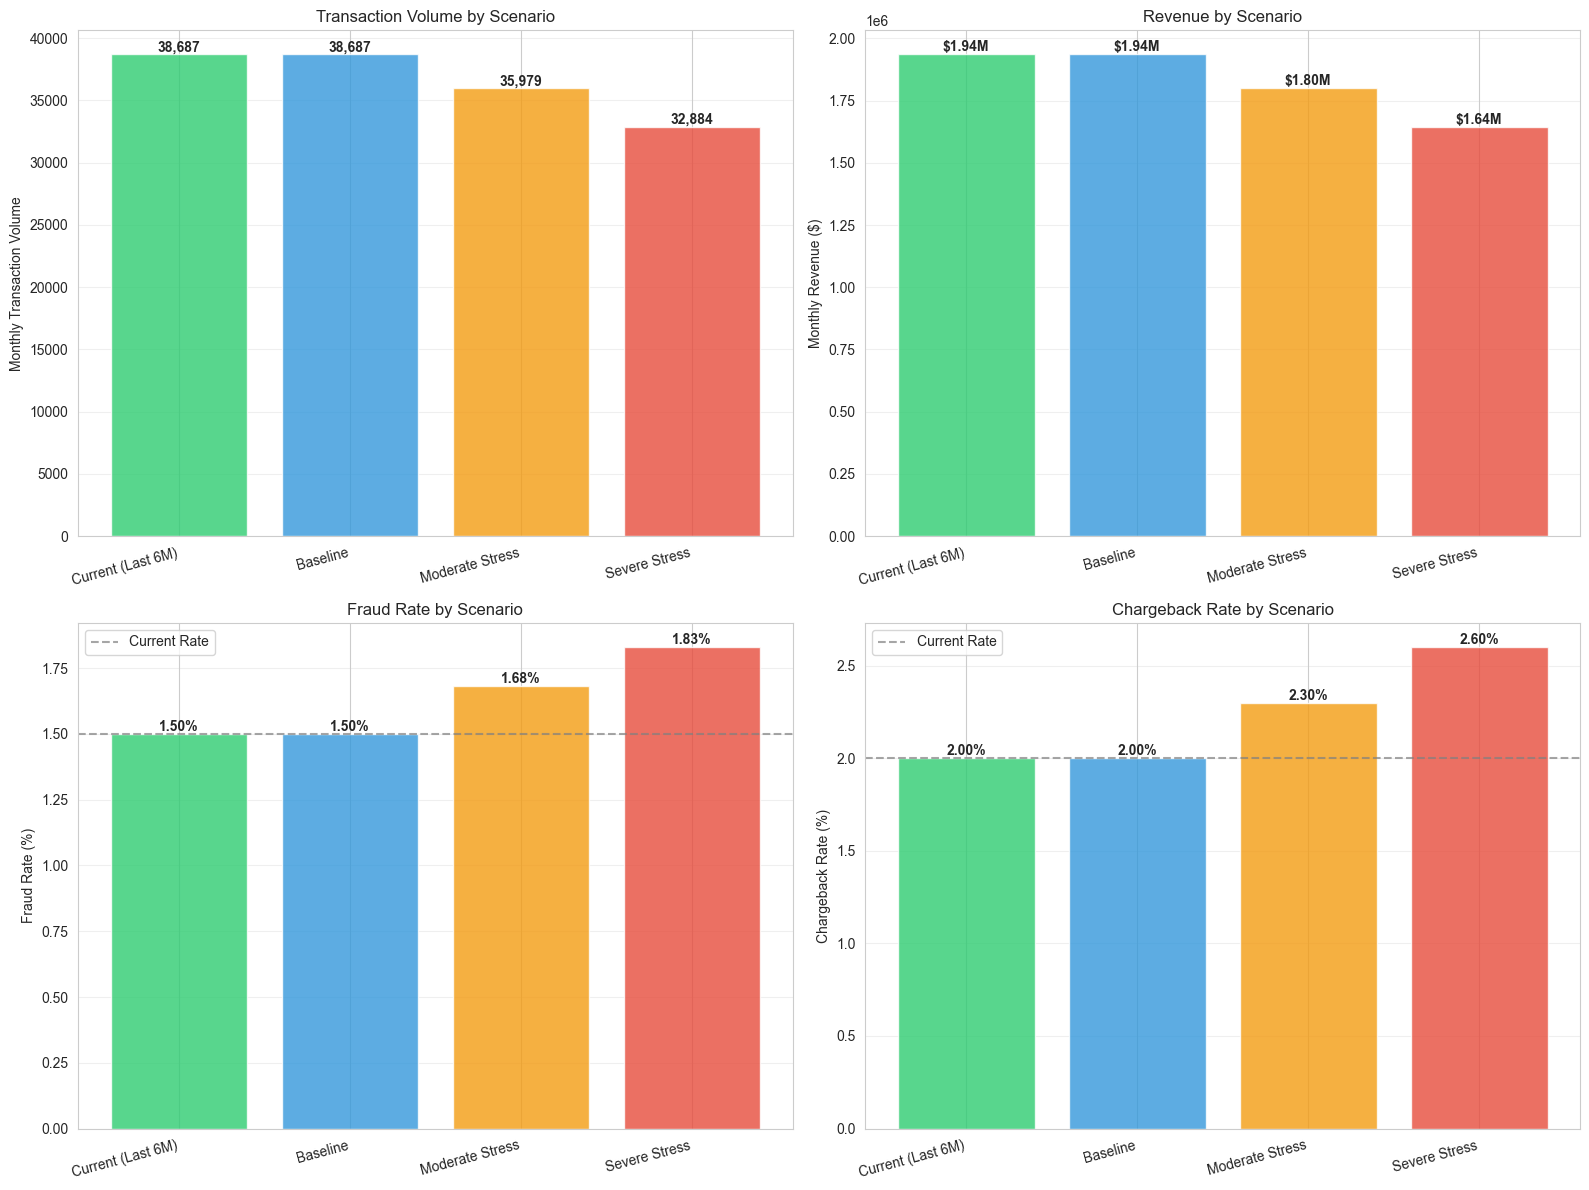

In [9]:
# Create visualization of scenario impacts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scenarios_list = ['Current (Last 6M)', 'Baseline', 'Moderate Stress', 'Severe Stress']
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

# 1. Transaction Volume
volumes = [projection_df.loc[s, 'monthly_volume'] for s in scenarios_list]
axes[0, 0].bar(range(len(scenarios_list)), volumes, color=colors, alpha=0.8)
axes[0, 0].set_xticks(range(len(scenarios_list)))
axes[0, 0].set_xticklabels(scenarios_list, rotation=15, ha='right')
axes[0, 0].set_ylabel('Monthly Transaction Volume')
axes[0, 0].set_title('Transaction Volume by Scenario')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(volumes):
    axes[0, 0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Monthly Revenue
revenues = [projection_df.loc[s, 'monthly_revenue'] for s in scenarios_list]
axes[0, 1].bar(range(len(scenarios_list)), revenues, color=colors, alpha=0.8)
axes[0, 1].set_xticks(range(len(scenarios_list)))
axes[0, 1].set_xticklabels(scenarios_list, rotation=15, ha='right')
axes[0, 1].set_ylabel('Monthly Revenue ($)')
axes[0, 1].set_title('Revenue by Scenario')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(revenues):
    axes[0, 1].text(i, v, f'${v/1e6:.2f}M', ha='center', va='bottom', fontweight='bold')

# 3. Fraud Rate
fraud_rates = [projection_df.loc[s, 'fraud_rate_pct'] for s in scenarios_list]
axes[1, 0].bar(range(len(scenarios_list)), fraud_rates, color=colors, alpha=0.8)
axes[1, 0].set_xticks(range(len(scenarios_list)))
axes[1, 0].set_xticklabels(scenarios_list, rotation=15, ha='right')
axes[1, 0].set_ylabel('Fraud Rate (%)')
axes[1, 0].set_title('Fraud Rate by Scenario')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=1.5, color='gray', linestyle='--', alpha=0.7, label='Current Rate')
for i, v in enumerate(fraud_rates):
    axes[1, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[1, 0].legend()

# 4. Chargeback Rate
chargeback_rates = [projection_df.loc[s, 'chargeback_rate_pct'] for s in scenarios_list]
axes[1, 1].bar(range(len(scenarios_list)), chargeback_rates, color=colors, alpha=0.8)
axes[1, 1].set_xticks(range(len(scenarios_list)))
axes[1, 1].set_xticklabels(scenarios_list, rotation=15, ha='right')
axes[1, 1].set_ylabel('Chargeback Rate (%)')
axes[1, 1].set_title('Chargeback Rate by Scenario')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=2.0, color='gray', linestyle='--', alpha=0.7, label='Current Rate')
for i, v in enumerate(chargeback_rates):
    axes[1, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

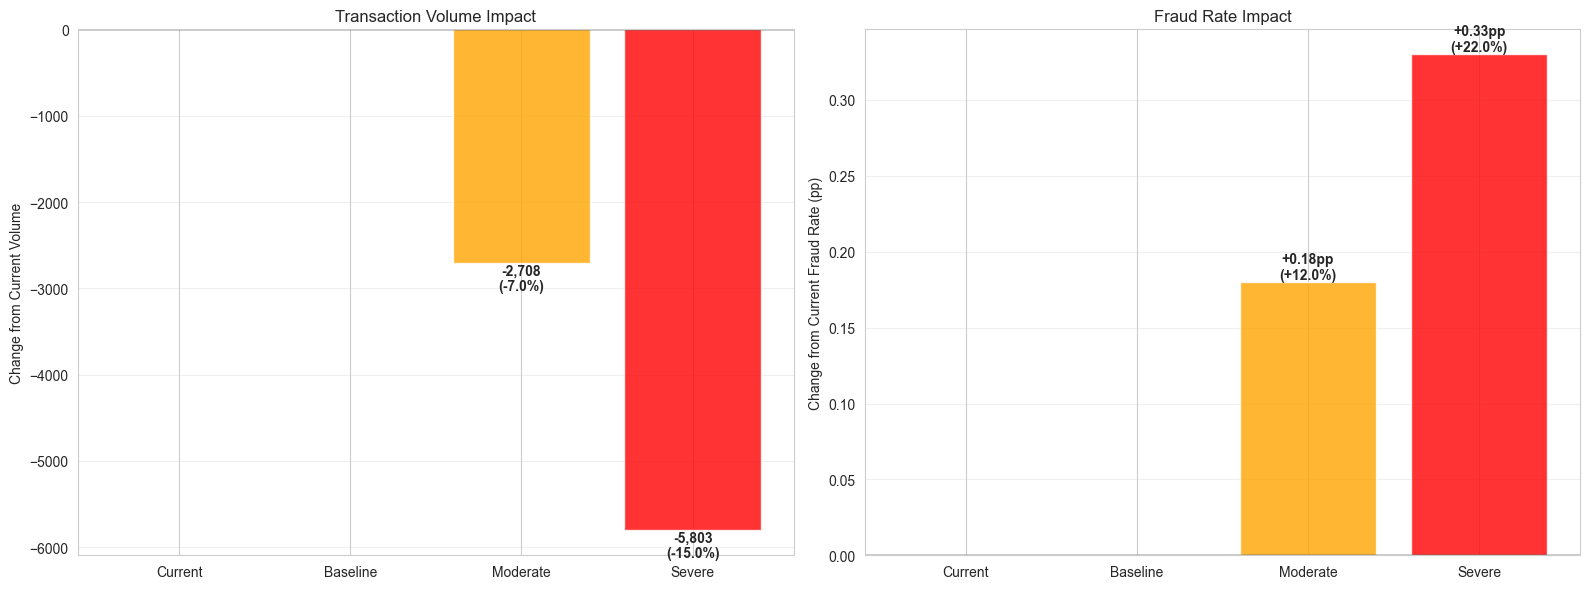

In [10]:
# Create waterfall-style impact chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Volume impact
baseline_vol = baseline_metrics['avg_monthly_volume']
vol_impacts = {
    'Current': 0,
    'Baseline': 0,
    'Moderate': (projections['Moderate Stress']['monthly_volume'] - baseline_vol),
    'Severe': (projections['Severe Stress']['monthly_volume'] - baseline_vol),
}

x_pos = range(len(vol_impacts))
colors_impact = ['gray', 'green', 'orange', 'red']
axes[0].bar(x_pos, vol_impacts.values(), color=colors_impact, alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(vol_impacts.keys())
axes[0].set_ylabel('Change from Current Volume')
axes[0].set_title('Transaction Volume Impact')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (k, v) in enumerate(vol_impacts.items()):
    if v != 0:
        axes[0].text(i, v, f'{v:,.0f}\n({v/baseline_vol*100:+.1f}%)', 
                    ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

# Fraud rate impact
baseline_fraud = 1.5
fraud_impacts = {
    'Current': 0,
    'Baseline': 0,
    'Moderate': (projections['Moderate Stress']['fraud_rate_pct'] - baseline_fraud),
    'Severe': (projections['Severe Stress']['fraud_rate_pct'] - baseline_fraud),
}

axes[1].bar(x_pos, fraud_impacts.values(), color=colors_impact, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(fraud_impacts.keys())
axes[1].set_ylabel('Change from Current Fraud Rate (pp)')
axes[1].set_title('Fraud Rate Impact')
axes[1].grid(True, alpha=0.3, axis='y')
for i, (k, v) in enumerate(fraud_impacts.items()):
    if v != 0:
        axes[1].text(i, v, f'{v:+.2f}pp\n({v/baseline_fraud*100:+.1f}%)', 
                    ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

---

## Executive Summary for Leadership and Engineering Teams

### Purpose

This analysis provides **directional impact estimates** for macroeconomic stress scenarios on:
- Payment transaction volumes
- Fraud rates
- Chargeback/dispute activity

**This is NOT predictive forecasting.** Scenarios are illustrative stress conditions based on historical patterns and analyst assessment.

---

### Key Findings

#### 1. Transaction Volume Impact

**Baseline Scenario (Current path):**
- No significant change expected
- Unemployment stable ~4%, Fed Funds declining to ~3.5%
- Consumer sentiment recovering

**Moderate Stress Scenario:**
- Volume decline: **-7%** (range: -5% to -8%)
- Driven by reduced discretionary spending
- Revenue impact: **-7%** proportional to volume

**Severe Stress Scenario:**
- Volume decline: **-15%** (range: -12% to -18%)
- Significant pullback in non-essential transactions
- Revenue impact: **-15%** proportional to volume

**Note:** Historical data showed volume INCREASE during prior unemployment spike, likely due to increased transaction velocity (more frequent, smaller transactions). Scenarios above assume discretionary spending decline dominates in rate/inflation-driven stress.

---

#### 2. Fraud Rate Impact

**First-Party Fraud (VALIDATED RISK):**

**Baseline:** No significant change (fraud rate ~1.5%)

**Moderate Stress:**
- Fraud rate increase: **+12%** (1.5% → 1.68%)
- Driven by credit stress and financial strain
- Fraud count increase: **+4%** (volume decline partially offsets rate increase)

**Severe Stress:**
- Fraud rate increase: **+22%** (1.5% → 1.83%)
- Based on historical application fraud spike (+22% in 2008-2010)
- Fraud count increase: **+4%** (volume decline partially offsets rate increase)

**Third-Party Fraud (NO MACRO CORRELATION):**
- Account takeover and synthetic identity fraud show NO historical correlation with macro conditions
- Maintain baseline vigilance; no scenario-based adjustment

---

#### 3. Chargeback & Dispute Impact

**VALIDATED RISK** with strong historical precedent:

**Baseline:** Chargeback rate ~2.0%

**Moderate Stress:**
- Chargeback rate increase: **+15%** (2.0% → 2.30%)
- Based on historical +12-18% increase with 3-6 month lag

**Severe Stress:**
- Chargeback rate increase: **+30%** (2.0% → 2.60%)
- Upper bound of historical range for severe conditions

**Concentration:** Disputes will concentrate in non-essential/discretionary categories

---

#### 4. Behavioral Shift Risks

**Payment Method Migration:**
- ACH share may increase (42% → 51% historically)
- Risk: Fraud rule sensitivity to method mix changes

**Transaction Pattern Changes:**
- Accelerated debt repayment (+18% avg payment historically)
- Risk: False positives on unusually large payments
- Credit utilization reduction
- Risk: Fraud rate distortion

**Timing:**
- Anticipatory behavior: Changes appear **6-9 months BEFORE** rate hikes
- May already be manifesting in current data

---

### Implications for Engineering

#### Immediate Actions (Baseline → Moderate Stress)

1. **Fraud Rule Review:**
   - Review rules sensitive to payment method mix
   - Evaluate thresholds for "unusually large" payment amounts
   - Consider behavioral shift impacts on model performance

2. **Monitoring Enhancements:**
   - Increase monitoring frequency for non-essential/discretionary categories
   - Track payment method mix trends
   - Monitor chargeback concentration by merchant category

3. **Capacity Planning:**
   - Dispute/chargeback handling capacity: plan for **+15%** volume
   - Fraud investigation resources: plan for **+4-12%** case volume

#### Contingency Planning (Severe Stress)

1. **Model Recalibration:**
   - Stress test fraud models against behavior shift scenarios
   - Prepare model updates for +20-30% fraud rate environment
   - Document model performance degradation thresholds

2. **Operational Capacity:**
   - Dispute handling: **+30%** capacity requirement
   - Fraud investigation: **+25-30%** case volume
   - Income/employment verification: Enhanced scrutiny

3. **System Performance:**
   - Volume may decline **-15%**, reducing infrastructure load
   - However, fraud/dispute processing increases
   - Net impact: Comparable or slightly reduced system load

---

### Limitations and Uncertainties

1. **Scenario-Based, Not Predictive:**
   - Scenarios are hypothetical stress conditions
   - Not probabilistic forecasts
   - Timing of any stress event is unknown

2. **Historical Precedent Limitations:**
   - Prior cycles driven by unemployment spikes
   - Current environment: rate/inflation-driven stress
   - Pattern similarity unvalidated

3. **Detection Capability Improvements:**
   - Fraud detection materially better than 2008-2010
   - May moderate fraud rate increases
   - Historical precedents may overstate impact

4. **Lag Timing Uncertainty:**
   - Historical lags: 3-6 months for chargebacks, 6-9 months for behavior
   - Anticipatory effects may already be manifesting
   - Easing cycle dynamics unknown

---

### Recommended Next Steps

1. **Monitoring:**
   - Track leading indicators: payment method mix, transaction patterns
   - Monitor chargeback trends by category
   - Track credit stress indicators (charge-offs, delinquencies)

2. **Validation:**
   - Conduct cohort-level analysis to validate segment elasticities
   - Stress test fraud models against scenario parameters
   - Quantify false positive risk from behavior shifts

3. **Planning:**
   - Use scenarios for capacity planning and resource allocation
   - Prepare contingency plans for Severe Stress scenario
   - Document trigger points for escalating response

4. **Communication:**
   - Share scenarios with operations, risk, and product teams
   - Establish common framework for discussing macro risk
   - Regular updates as economic conditions evolve

---

## Conclusion

These scenario projections provide a framework for understanding potential directional impacts of macroeconomic stress on payment activity. The analysis is transparent, explainable, and deliberately simple to support planning conversations.

**Key takeaways:**
- Baseline scenario: Stable conditions, no significant changes
- Moderate stress: -7% volume, +12% fraud rate, +15% chargebacks
- Severe stress: -15% volume, +22% fraud rate, +30% chargebacks
- Behavioral shifts require model and rule review
- Third-party fraud has no macro correlation

Use these estimates for planning, not prediction. Monitor leading indicators and validate assumptions as conditions evolve.